In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedKFold
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [31]:
df = pd.read_csv('train.csv')

In [10]:
#переводим Y в бинарное значения для классификации
#x = {'yes': 1, 'no': 0}
#df['target'] = df['target'].map(x)

# Подготовка переменных

In [34]:
dum_vars=['job','marital','education','default','housing','loan','contact','month',
          'day_of_week','poutcome','previous','_id','target']

In [35]:
for_preprocess = df.columns.values.tolist()

In [36]:
for_preprocess_v = [v for v in for_preprocess if v not in dum_vars  and v != 'y']

In [37]:
df_ = df[for_preprocess_v]

In [536]:
dum_vars=['housing','loan']

In [537]:
#создаем dummy variables для колонок с категориальными переменными.
for var in dum_vars:
    dummies = pd.get_dummies(df[var], prefix = var)
    #df = df.drop(var,axis = 1)
    df_ = df_.join(dummies)

# TO-DO Подготовить категориальные переменные.

На выходе train и test с категориальными переменными.

# Подготовка train, test

In [38]:
y = df['target']
X = df_
#X = df.drop('y', axis=1)

In [39]:
from sklearn import preprocessing
normalized_X = preprocessing.normalize(X)
standardized_X = preprocessing.scale(X)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1234)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [41]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Тренировка модели. Логистическая регрессия.

In [42]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [43]:
#Прогноз на тестовом сете
y_pred = logreg.predict(X_test)
print('Точность классификатора на тесте: {:.2f}'.format(logreg.score(X_test, y_test)))

Точность классификатора на тесте: 0.91


# Оценка точности модели

In [44]:
#валидация
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=42)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("Средняя точность на 10 фолдах: %.3f" % (results.mean()))

Средняя точность на 10 фолдах: 0.908


Ниже видно, что recall низкий. Это из за дисбаланса классов

In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.92      0.98      0.95      4383
          1       0.68      0.36      0.47       560

avg / total       0.90      0.91      0.90      4943



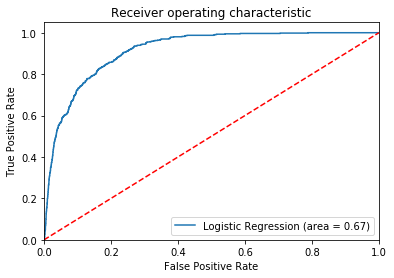

In [46]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Площадь под кривой 0.87. Модель возвращает 87% true positive результатов из всех возможных.

In [47]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[4289   94]
 [ 357  203]]


# Балансировка выборки. Потому что можем.

In [63]:
df['target'].value_counts()

0    21925
1     2787
Name: target, dtype: int64

Выборка не сбалансирована. В виду ограничения времени используем один метод и сбалансируем выборку вверх. 

In [64]:
from sklearn.utils import resample
df_majority = df[df.target == 0]
df_minority = df[df.target == 1]

In [65]:
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=21925,    # to match majority class
                                 random_state=42) 

In [66]:
# объедими выборки
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [67]:
df_upsampled['target'].value_counts()

1    21925
0    21925
Name: target, dtype: int64

In [68]:
df_ = df_upsampled

In [69]:
df_ = df_upsampled[for_preprocess_v]

In [552]:
dum_vars=['housing','loan']

In [553]:
#создаем dummy variables для колонок с категориальными переменными.
for var in dum_vars:
    dummies = pd.get_dummies(df[var], prefix = var)
    #df = df.drop(var,axis = 1)
    df_ = df_.join(dummies)

In [70]:
y = df_upsampled['target']
X = df_

In [71]:
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X, y, train_size=0.8, random_state=1234)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [72]:
from sklearn.preprocessing import StandardScaler
X_train_up = sc.transform(X_train_up)
X_test_up = sc.transform(X_test_up)

In [73]:
logreg = LogisticRegression()
logreg.fit(X_train_up, y_train_up)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [74]:
#Прогноз на тестовом сете
y_pred = logreg.predict(X_test_up)
print('Точность классификатора на тесте: {:.2f}'.format(logreg.score(X_test_up, y_test_up)))

Точность классификатора на тесте: 0.85


In [75]:
from sklearn.metrics import classification_report
print(classification_report(y_test_up, y_pred))

             precision    recall  f1-score   support

          0       0.84      0.85      0.85      4342
          1       0.86      0.85      0.85      4428

avg / total       0.85      0.85      0.85      8770



In [23]:
#Прогноз на тестовом сете
y_pred = logreg.predict(X_test)
print('Точность классификатора на тесте: {:.2f}'.format(logreg.score(X_test, y_test)))

Точность классификатора на тесте: 0.86


In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      0.86      0.92       586
          1       0.39      0.88      0.54        59

avg / total       0.93      0.86      0.88       645



In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[503  83]
 [  7  52]]


# Тренировка модели. Решающие деревья.

# TO - DO
[ ] Сделать подбор параметров <br>

In [83]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 2000, criterion = 'gini', random_state = 0, max_depth=200)
classifier.fit(X_train_up, y_train_up)

# Predicting the Test set results
y_pred = classifier.predict(X_test_up)

In [84]:
# Predicting the Test set results
y_pred = classifier.predict(X_test_up)

In [85]:
print(classification_report(y_test_up, y_pred))

             precision    recall  f1-score   support

          0       1.00      0.93      0.96      4342
          1       0.94      1.00      0.97      4428

avg / total       0.97      0.96      0.96      8770



In [126]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test_up, y_pred)
print(confusion_matrix)

[[514  48]
 [  1 581]]


In [86]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [128]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[577   9]
 [  0  59]]


In [129]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      0.98      0.99       586
          1       0.87      1.00      0.93        59

avg / total       0.99      0.99      0.99       645



In [33]:
feature_importances = pd.DataFrame(classifier.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [86]:
feature_importances

,importance
duration,0.485198
euribor3m,0.144550
age,0.095540
nr.employed,0.087665
campaign,0.045132
cons.conf.idx,0.041917
emp.var.rate,0.041220
cons.price.idx,0.032867
pdays,0.025911


In [42]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=3500,
    learning_rate=0.05,
    od_type='Iter',
    od_wait=20,
    eval_metric = 'Logloss',
)
print ('Model is fitted:', model.is_fitted_)
print ('Model params:', model.get_params())

Model is fitted: False
Model params: {'eval_metric': 'Logloss', 'od_type': 'Iter', 'od_wait': 20, 'loss_function': 'Logloss', 'learning_rate': 0.05, 'iterations': 3500}


In [43]:
model.fit(
    X_train_up, y_train_up,
    eval_set=(X_test_up, y_test_up),
    logging_level='Silent',
)

In [44]:
y_pred = model.predict(data=X_test)

In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[564  22]
 [  0  59]]


# Тренировка модели. KNN

# Пока здесь пустынно TO-DO

# Прогноз на тестовой выборке

In [93]:
#Строим прогноз на новых данных. Модель обучена. Препроцессинг тестовых данных, построить прогноз, выгрузить в excel. 
df_test = pd.read_csv('test.csv')

In [94]:
X_ = df_test[for_preprocess_v]

In [95]:
X_ = sc.transform(X_)

In [96]:
y_pred = classifier.predict(X_)

In [79]:
y_pred = logreg.predict(X_)

In [97]:
df_test['target']= y_pred

In [98]:
df_test = df_test[['_id','target']]

In [99]:
df_test.to_csv('submit.csv',index=False)